Лабораторная работа 2. Провести предобработку данных. Разбить на тестовую и обучающую выборки (не забыть про кросс-валидацию).

In [7]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GroupKFold

import json
import csv

from prefs import prefs

INPUT_JSON = "data/full_data.json"
OUTPUT_CSV = "data/osm_nodes.csv"

Загрузка данных

In [8]:
with open(INPUT_JSON, "r", encoding="utf-8") as f:
    data = json.load(f)

nodes = [el for el in data.get("elements", []) if el.get("type") == "node"]

tag_keys = []
for node in nodes:

    x = node.get("tags", {}).get("tourism", {})
    if x == "yes":
        tag_keys.append("tourism")
    elif x != "no":
        tag_keys.append(node.get("tags", {}).get("tourism", {}))
    
    x = node.get("tags", {}).get("historic", {})
    if x == "yes":
        tag_keys.append("historic")
    elif x != "no":
        tag_keys.append(node.get("tags", {}).get("historic", {}))

    x = node.get("tags", {}).get("amenity", {})
    if x == "yes":
        tag_keys.append("amenity")
    elif x != "no":
        tag_keys.append(node.get("tags", {}).get("amenity", {}))

    x = node.get("tags", {}).get("leisure", {})
    if x == "yes":
        tag_keys.append("leisure")
    elif x != "no":
        tag_keys.append(node.get("tags", {}).get("leisure", {}))

tags = set()
for i in tag_keys:
    if i != {}:
        tags.add(i)

print("Всего тегов:",len(tags))
print("Теги:",tags)



Всего тегов: 79
Теги: {'information', 'train', 'swimming_pool', 'stone', 'social_facility', 'caravan_site', 'chalet', 'statue', 'garden', 'battlefield', 'archaeological_site', 'attraction', 'exhibit', 'hotel', 'sauna', 'museum', 'cannon', 'milestone', 'ship', 'memorial', 'printing_press', 'mine', 'amusement_arcade', 'tomb', 'dormitory', 'technical_monument', 'castle', 'shield', 'epigraph', 'water_park', 'boundary_stone', 'wayside_cross', 'missile', 'binoculars', 'ruins', 'wayside_shrine', 'anchor', 'artwork', 'aquarium', 'cross', 'hostel', 'railway_station', 'viewpoint', 'picnic_table', 'camp_site', 'gate', 'suburb', 'grave', 'manor', 'bench', 'tank', 'lean_to', 'city_gate', 'theme_park', 'hospital', 'training', 'restaurant', 'guest_house', 'propeller', 'place_of_worship', 'locomotive', 'trail_riding_station', 'aircraft', 'railway_car', 'wreck', 'picnic_site', 'church', 'vehicle', 'library', 'dog_park', 'apartment', 'cafe', 'zoo', 'gallery', 'clock', 'monument', 'historic', 'motel', 'f

Преобразование в CSV

In [9]:
fieldnames = ["id", "lat", "lon", "name", "description", "inscription"] + sorted(tags)

with open(OUTPUT_CSV, "w", newline="", encoding="utf-8") as f:
    writer = csv.DictWriter(f, fieldnames=fieldnames)
    writer.writeheader()

    for node in nodes:
        row = {
            "id": node.get("id"),
            "lat": node.get("lat"),
            "lon": node.get("lon")
        }
        row["name"] = node.get("tags").get("name")
        row["description"] = node.get("tags").get("description")
        row["inscription"] = node.get("tags").get("inscription")
        

        if row["name"] == None:
            row["name"] = row["description"]

        if row["description"] == None:
            row["description"] = row["inscription"]

        if row["inscription"] == None:
            row["inscription"] = row["name"]

        if row["description"] == None:
            row["description"] = row["inscription"]
        
        if row["name"] == None:
            row["name"] = "Место-сюрприз"
        if row["description"] == None:
            row["description"] = "Место-сюрприз"
        if row["inscription"] == None:
            row["inscription"] = "Место-сюрприз"

        for key in tags:
            if(node.get("tags", {}).get(key, "")):
                row[key] = True
            else:
                row[key] = False
        writer.writerow(row)

print(f"Сохранено {len(nodes)} нод в {OUTPUT_CSV}")

Сохранено 7266 нод в data/osm_nodes.csv


In [10]:
df = pd.read_csv(OUTPUT_CSV, encoding="utf-8")

# df[binary_cols] = df[binary_cols].astype("int8")

df.info()
df.head()

# base_cols = {"id", "lat", "lon", "name", "description", "inscription"}
# binary_cols = [c for c in df.columns if c not in base_cols]
# df[binary_cols].sum().sort_values(ascending=False).head(20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7266 entries, 0 to 7265
Data columns (total 85 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    7266 non-null   int64  
 1   lat                   7266 non-null   float64
 2   lon                   7266 non-null   float64
 3   name                  7266 non-null   object 
 4   description           7266 non-null   object 
 5   inscription           7266 non-null   object 
 6   aircraft              7266 non-null   bool   
 7   amusement_arcade      7266 non-null   bool   
 8   anchor                7266 non-null   bool   
 9   apartment             7266 non-null   bool   
 10  aquarium              7266 non-null   bool   
 11  archaeological_site   7266 non-null   bool   
 12  artwork               7266 non-null   bool   
 13  attraction            7266 non-null   bool   
 14  battlefield           7266 non-null   bool   
 15  bench                

,id,lat,lon,name,description,inscription,aircraft,amusement_arcade,anchor,apartment,aquarium,archaeological_site,artwork,attraction,battlefield,bench,binoculars,boundary_stone,cafe,camp_site,cannon,caravan_site,castle,chalet,church,city_gate,clock,cross,dog_park,dormitory,epigraph,exhibit,fountain,gallery,garden,gate,grave,guest_house,historic,hospital,...,locomotive,manor,memorial,milestone,mine,missile,monument,motel,museum,picnic_site,picnic_table,place_of_worship,printing_press,propeller,railway_car,railway_station,restaurant,ruins,sauna,shield,ship,social_facility,statue,stone,suburb,swimming_pool,tank,technical_monument,theme_park,tomb,trail_riding_station,train,training,vehicle,viewpoint,water_park,wayside_cross,wayside_shrine,wreck,zoo
0,2,59.771793,30.326110,Центр круглого зала,Центр круглого зала,Центр круглого зала,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,238809,60.189557,29.700233,Башмаки неизвестного дачника (2009),Башмаки неизвестного дачника (2009),Башмаки неизвестного дачника (2009),False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,21626280,59.946264,30.395801,В. И. Ленин,В. И. Ленин,В. И. Ленин,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,...,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,21751966,60.039200,30.296405,Озёрная,Озёрная,Озёрная,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
4,80317281,59.970296,30.386136,М. И. Калинин,М. И. Калинин,М. И. Калинин,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,...,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


Добавление столбца Score

In [46]:
import random
random.seed(10)

poi_cols = [col for col in prefs.keys() if col in df.columns]

poi_matrix = df[poi_cols]

weights = pd.Series([prefs[col] for col in poi_cols], index=poi_cols)

df['score'] = poi_matrix.dot(weights) + random.uniform(-2.0, 2.0)

df[['id', 'name', 'score'] + poi_cols].head()

,id,name,score,historic,archaeological_site,ruins,battlefield,memorial,milestone,boundary_stone,epigraph,museum,technical_monument,exhibit,artwork,gallery,library,locomotive,train,railway_car,railway_station,aircraft,ship,vehicle,tank,cannon,missile,anchor,propeller,shield,wreck,mine,printing_press,monument,statue,clock,gate,city_gate,manor,castle,...,binoculars,information,cafe,restaurant,bench,garden,fountain,hotel,hostel,guest_house,motel,apartment,dormitory,chalet,camp_site,caravan_site,lean_to,amusement_arcade,theme_park,water_park,zoo,aquarium,swimming_pool,dog_park,social_facility,hospital,training,place_of_worship,church,wayside_cross,cross,wayside_shrine,tomb,grave,attraction,picnic_site,picnic_table,trail_riding_station,suburb,sauna
0,2,Центр круглого зала,2.28561,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,238809,Башмаки неизвестного дачника (2009),0.28561,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,21626280,В. И. Ленин,4.28561,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,21751966,Озёрная,3.28561,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,80317281,М. И. Калинин,4.28561,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [47]:
df[['id', 'name', 'score']].sort_values('score', ascending=False).head(10)

,id,name,score
3507,7548851416,Город Пушкин,6.28561
3489,7485870895,Часовня святого благоверного князя Игоря Черни...,6.28561
5335,10915989243,Проспект Ю. Гагарина,6.28561
343,1280066306,"ДОТ ""Миллионер""",6.28561
243,1123474657,Памятник императору Николаю I,5.28561
224,1041154862,Пётр I,5.28561
6,242160221,Родина-Мать,5.28561
8,249082841,Петру Великому,5.28561
379,1312226165,Александру III,5.28561
4517,9352981941,Место-сюрприз,4.28561


Разбиение на тестовую и обучающую выборки

In [48]:
train_idx, test_idx = train_test_split(
    df.index,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

df['split'] = 'train'
df.loc[test_idx, 'split'] = 'test'
df['split'].value_counts()

split
train    5812
test     1454
Name: count, dtype: int64

In [49]:
N_FOLDS = 5
kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

df['fold'] = -1

for fold_number, (_, test_idx) in enumerate(kf.split(df)):
    df.loc[test_idx, 'fold'] = fold_number

df['fold'].value_counts().sort_index()

fold
0    1454
1    1453
2    1453
3    1453
4    1453
Name: count, dtype: int64

In [50]:
train_df = df[df['fold'] != 2]
test_df  = df[df['fold'] == 2]

X_train = train_df[poi_cols]
y_train = train_df['score']

X_test = test_df[poi_cols]
y_test = test_df['score']

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

Лабораторная работа 3. Реализовать модель на обучающей выборке. Поэкспериментировать с разными параметрами. Сделать выводы. Не менее 10 экспериментов.

В третьей лабораторной обязательно провести следующие эксперименты:
1. Простой запуск с базовой настройкой
2. Изменение количества эпох (3 варианта)
3. Изменение количества batch_size (3 варианта)
4. Изменение learning_rate или аналогичного по значению параметра
5. Эксперименты с функциями активации (2 варианта)
6. Эксперименты с архитектурой сети (меняем количество и порядок слоев) (3 варианта)

По каждому эксперименту делаете вывод и собираете комбинацию их лучших экспериментов, по ней тоже делаете вывод

1. Простой запуск с базовой настройкой

In [51]:
print(X_train)
print(X_train.dtypes)
print(y_train.dtypes)

      historic  archaeological_site  ruins  ...  trail_riding_station  suburb  sauna
0          1.0                  0.0    0.0  ...                   0.0     0.0    0.0
1          0.0                  0.0    0.0  ...                   0.0     0.0    0.0
2          1.0                  0.0    0.0  ...                   0.0     0.0    0.0
3          0.0                  0.0    0.0  ...                   0.0     0.0    0.0
4          1.0                  0.0    0.0  ...                   0.0     0.0    0.0
...        ...                  ...    ...  ...                   ...     ...    ...
7257       0.0                  0.0    0.0  ...                   0.0     0.0    0.0
7259       0.0                  0.0    0.0  ...                   0.0     0.0    0.0
7260       0.0                  0.0    0.0  ...                   0.0     0.0    0.0
7262       1.0                  0.0    0.0  ...                   0.0     0.0    0.0
7264       0.0                  0.0    0.0  ...                  

In [109]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

import time

input_dim = X_train.shape[1]  # количество признаков

results = {}

# ТЕСТ 1 - БАЗОВЫЙ ЗАПУСК (Эпохи: 50, batch_size: 32, learning_rate: 0.001, функция_активации: ReLU, архитектура_сети: 32-16-1)

start_time = time.time()

model = Sequential([
    Dense(32, activation='relu', input_dim=input_dim),
    Dense(16, activation='relu'),
    Dense(1, activation='linear')
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

test_loss, test_mae = model.evaluate(X_test, y_test, verbose=1)

training_time = time.time() - start_time

print(f"1. Базовый_запуск:\nTIME: {training_time}\nMSE: {test_loss:.4f}\nMAE: {test_mae:.4f}")

results["1. Базовый_запуск"] = [training_time, test_loss, test_mae]

Epoch 1/50


c:\Users\kiril\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.1736 - mae: 1.2324 - val_loss: 0.4361 - val_mae: 0.5787
Epoch 2/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2251 - mae: 0.3995 - val_loss: 0.0419 - val_mae: 0.1597
Epoch 3/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0222 - mae: 0.0690 - val_loss: 0.0115 - val_mae: 0.0370
Epoch 4/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0078 - mae: 0.0199 - val_loss: 0.0064 - val_mae: 0.0125
Epoch 5/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0032 - mae: 0.0098 - val_loss: 0.0048 - val_mae: 0.0062
Epoch 6/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0017 - mae: 0.0055 - val_loss: 0.0045 - val_mae: 0.0047
Epoch 7/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0012 - mae: 0.0042 - val_loss: 0.0045 - val_mae: 0.0039
Epoch 8/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.6554e-04 - mae: 0.0035 - val_loss: 0.0044 - val_mae: 0.0041
Epoch 9/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.5

In [110]:
# ТЕСТ 2 - Эпохи: 5

start_time = time.time()

model = Sequential([
    Dense(32, activation='relu', input_dim=input_dim),
    Dense(16, activation='relu'),
    Dense(1, activation='linear')
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

history = model.fit(
    X_train, y_train,
    epochs=5,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

test_loss, test_mae = model.evaluate(X_test, y_test, verbose=1)

training_time = time.time() - start_time

print(f"2. Эпохи: 5:\nTIME: {training_time}\nMSE: {test_loss:.4f}\nMAE: {test_mae:.4f}")

results["2. Эпохи: 5"] = [training_time, test_loss, test_mae]

Epoch 1/5


c:\Users\kiril\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.3455 - mae: 1.0633 - val_loss: 0.2616 - val_mae: 0.4573
Epoch 2/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0978 - mae: 0.2328 - val_loss: 0.0113 - val_mae: 0.0532
Epoch 3/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0086 - mae: 0.0268 - val_loss: 0.0037 - val_mae: 0.0135
Epoch 4/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0045 - mae: 0.0086 - val_loss: 0.0030 - val_mae: 0.0065
Epoch 5/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0036 - mae: 0.0063 - val_loss: 0.0027 - val_mae: 0.0084
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0022 - mae: 0.0072 
2. Эпохи: 5:
TIME: 2.024848461151123
MSE: 0.0022
MAE: 0.0072


In [111]:
# ТЕСТ 3 - Эпохи: 1

start_time = time.time()

model = Sequential([
    Dense(32, activation='relu', input_dim=input_dim),
    Dense(16, activation='relu'),
    Dense(1, activation='linear')
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

history = model.fit(
    X_train, y_train,
    epochs=1,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

test_loss, test_mae = model.evaluate(X_test, y_test, verbose=1)

training_time = time.time() - start_time

print(f"3. Эпохи: 1:\nTIME: {training_time}\nMSE: {test_loss:.4f}\nMAE: {test_mae:.4f}")

results["3. Эпохи: 1"] = [training_time, test_loss, test_mae]

c:\Users\kiril\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.2112 - mae: 1.0049 - val_loss: 0.1676 - val_mae: 0.3572
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1957 - mae: 0.3999 
3. Эпохи: 1:
TIME: 1.1279010772705078
MSE: 0.1957
MAE: 0.3999


In [112]:
# ТЕСТ 4 - batch_size: 16

start_time = time.time()

model = Sequential([
    Dense(32, activation='relu', input_dim=input_dim),
    Dense(16, activation='relu'),
    Dense(1, activation='linear')
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

test_loss, test_mae = model.evaluate(X_test, y_test, verbose=1)

training_time = time.time() - start_time

print(f"4. batch_size: 16:\nTIME: {training_time}\nMSE: {test_loss:.4f}\nMAE: {test_mae:.4f}")

results["4. batch_size: 16"] = [training_time, test_loss, test_mae]

Epoch 1/50


c:\Users\kiril\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.7253 - mae: 1.1377 - val_loss: 0.2525 - val_mae: 0.4334
Epoch 2/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0807 - mae: 0.1873 - val_loss: 0.0135 - val_mae: 0.0388
Epoch 3/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0093 - mae: 0.0221 - val_loss: 0.0042 - val_mae: 0.0164
Epoch 4/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0032 - mae: 0.0092 - val_loss: 0.0025 - val_mae: 0.0096
Epoch 5/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0019 - mae: 0.0058 - val_loss: 0.0023 - val_mae: 0.0034
Epoch 6/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0013 - mae: 0.0042 - val_loss: 0.0023 - val_mae: 0.0074
Epoch 7/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.6496e-04 - mae: 0.0039 - val_loss: 0.0022 - val_mae: 0.0032
Epoch 8/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.1335e-04 - mae: 0.0035 - val_loss: 0.0022 - val_mae: 0.0026
Epoch 9/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss:

In [113]:
# ТЕСТ 5 - batch_size: 8

start_time = time.time()

model = Sequential([
    Dense(32, activation='relu', input_dim=input_dim),
    Dense(16, activation='relu'),
    Dense(1, activation='linear')
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=8,
    validation_split=0.2,
    verbose=1
)

test_loss, test_mae = model.evaluate(X_test, y_test, verbose=1)

training_time = time.time() - start_time

print(f"5. batch_size: 8:\nTIME: {training_time}\nMSE: {test_loss:.4f}\nMAE: {test_mae:.4f}")

results["5. batch_size: 8"] = [training_time, test_loss, test_mae]

Epoch 1/50


c:\Users\kiril\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.8025 - mae: 0.4330 - val_loss: 0.0091 - val_mae: 0.0301
Epoch 2/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0057 - mae: 0.0158 - val_loss: 0.0060 - val_mae: 0.0178
Epoch 3/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0014 - mae: 0.0062 - val_loss: 0.0054 - val_mae: 0.0071
Epoch 4/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 6.0387e-04 - mae: 0.0038 - val_loss: 0.0052 - val_mae: 0.0059
Epoch 5/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2.3500e-04 - mae: 0.0026 - val_loss: 0.0053 - val_mae: 0.0070
Epoch 6/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 9.5276e-05 - mae: 0.0022 - val_loss: 0.0053 - val_mae: 0.0075
Epoch 7/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 6.2916e-05 - mae: 0.0021 - val_loss: 0.0052 - val_mae: 0.0036
Epoch 8/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 4.0790e-05 - mae: 0.0017 - val_loss: 0.0051 - val_mae: 0.0038
Epoch 9/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/

In [114]:
# ТЕСТ 6 - learning_rate=0.01

start_time = time.time()

model = Sequential([
    Dense(32, activation='relu', input_dim=input_dim),
    Dense(16, activation='relu'),
    Dense(1, activation='linear')
])

model.compile(
    optimizer=Adam(learning_rate=0.01),
    loss='mse',
    metrics=['mae']
)

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

test_loss, test_mae = model.evaluate(X_test, y_test, verbose=1)

training_time = time.time() - start_time

print(f"6. learning_rate: 0.01:\nTIME: {training_time}\nMSE: {test_loss:.4f}\nMAE: {test_mae:.4f}")

results["6. learning_rate: 0.01"] = [training_time, test_loss, test_mae]

Epoch 1/50


c:\Users\kiril\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5677 - mae: 0.3060 - val_loss: 0.0034 - val_mae: 0.0154
Epoch 2/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0010 - mae: 0.0047 - val_loss: 0.0029 - val_mae: 0.0048
Epoch 3/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.0081e-04 - mae: 0.0029 - val_loss: 0.0027 - val_mae: 0.0058
Epoch 4/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.9170e-04 - mae: 0.0037 - val_loss: 0.0036 - val_mae: 0.0070
Epoch 5/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.2626e-04 - mae: 0.0066 - val_loss: 0.0028 - val_mae: 0.0042
Epoch 6/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.4031e-04 - mae: 0.0029 - val_loss: 0.0028 - val_mae: 0.0051
Epoch 7/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.2566e-04 - mae: 0.0044 - val_loss: 0.0029 - val_mae: 0.0059
Epoch 8/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.1276e-04 - mae: 0.0087 - val_loss: 0.0047 - val_mae: 0.0139
Epoch 9/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [115]:
# ТЕСТ 7 - learning_rate=0.1

start_time = time.time()

model = Sequential([
    Dense(32, activation='relu', input_dim=input_dim),
    Dense(16, activation='relu'),
    Dense(1, activation='linear')
])

model.compile(
    optimizer=Adam(learning_rate=0.1),
    loss='mse',
    metrics=['mae']
)

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

test_loss, test_mae = model.evaluate(X_test, y_test, verbose=1)

training_time = time.time() - start_time

print(f"7. learning_rate: 0.1:\nTIME: {training_time}\nMSE: {test_loss:.4f}\nMAE: {test_mae:.4f}")

results["7. learning_rate: 0.1"] = [training_time, test_loss, test_mae]

Epoch 1/50


c:\Users\kiril\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1279 - mae: 0.1256 - val_loss: 0.0058 - val_mae: 0.0290
Epoch 2/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0012 - mae: 0.0108 - val_loss: 0.0056 - val_mae: 0.0316
Epoch 3/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0047 - mae: 0.0364 - val_loss: 0.0057 - val_mae: 0.0249
Epoch 4/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0068 - mae: 0.0408 - val_loss: 0.0125 - val_mae: 0.0647
Epoch 5/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0097 - mae: 0.0505 - val_loss: 0.0146 - val_mae: 0.0617
Epoch 6/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0429 - mae: 0.1099 - val_loss: 0.0274 - val_mae: 0.1052
Epoch 7/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0027 - mae: 0.0231 - val_loss: 0.0041 - val_mae: 0.0085
Epoch 8/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.9734e-04 - mae: 0.0086 - val_loss: 0.0040 - val_mae: 0.0059
Epoch 9/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0

In [116]:
# ТЕСТ 8 - функция_активации: softmax

start_time = time.time()

model = Sequential([
    Dense(32, activation='softmax', input_dim=input_dim),
    Dense(16, activation='softmax'),
    Dense(1, activation='linear')
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

test_loss, test_mae = model.evaluate(X_test, y_test, verbose=1)

training_time = time.time() - start_time

print(f"8. функция_активации: softmax:\nTIME: {training_time}\nMSE: {test_loss:.4f}\nMAE: {test_mae:.4f}")

results["8. функция_активации: softmax"] = [training_time, test_loss, test_mae]

Epoch 1/50


c:\Users\kiril\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.1885 - mae: 1.5435 - val_loss: 3.5124 - val_mae: 1.3835
Epoch 2/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.2759 - mae: 1.4982 - val_loss: 2.8227 - val_mae: 1.3397
Epoch 3/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.6643 - mae: 1.5064 - val_loss: 2.3752 - val_mae: 1.2985
Epoch 4/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.2462 - mae: 1.5093 - val_loss: 2.0801 - val_mae: 1.2549
Epoch 5/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.9299 - mae: 1.4900 - val_loss: 1.8529 - val_mae: 1.1997
Epoch 6/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.6245 - mae: 1.4394 - val_loss: 1.6122 - val_mae: 1.1129
Epoch 7/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2349 - mae: 1.3265 - val_loss: 1.2850 - val_mae: 0.9700
Epoch 8/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7483 - mae: 1.1500 - val_loss: 0.9240 - val_mae: 0.7793
Epoch 9/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2768 

In [117]:
# ТЕСТ 9 - архитектура_сети: 4-2-1

start_time = time.time()

model = Sequential([
    Dense(4, activation='relu', input_dim=input_dim),
    Dense(2, activation='relu'),
    Dense(1, activation='linear')
])

model.compile(
    optimizer=Adam(learning_rate=0.1),
    loss='mse',
    metrics=['mae']
)

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

test_loss, test_mae = model.evaluate(X_test, y_test, verbose=1)

training_time = time.time() - start_time

print(f"9. архитектура_сети: 4-2-1:\nTIME: {training_time}\nMSE: {test_loss:.4f}\nMAE: {test_mae:.4f}")

results["9. архитектура_сети: 4-2-1"] = [training_time, test_loss, test_mae]

Epoch 1/50


c:\Users\kiril\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2564 - mae: 0.1802 - val_loss: 0.0437 - val_mae: 0.0414
Epoch 2/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0529 - mae: 0.0435 - val_loss: 0.0446 - val_mae: 0.0274
Epoch 3/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0535 - mae: 0.0433 - val_loss: 0.0445 - val_mae: 0.0535
Epoch 4/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0534 - mae: 0.0480 - val_loss: 0.0436 - val_mae: 0.0267
Epoch 5/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0535 - mae: 0.0481 - val_loss: 0.0446 - val_mae: 0.0600
Epoch 6/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0546 - mae: 0.0542 - val_loss: 0.0451 - val_mae: 0.0439
Epoch 7/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0545 - mae: 0.0538 - val_loss: 0.0443 - val_mae: 0.0238
Epoch 8/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0547 - mae: 0.0582 - val_loss: 0.0435 - val_mae: 0.0295
Epoch 9/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0545 

In [118]:
# ТЕСТ 10 - архитектура_сети: 8-4-1

start_time = time.time()

model = Sequential([
    Dense(8, activation='relu', input_dim=input_dim),
    Dense(4, activation='relu'),
    Dense(1, activation='linear')
])

model.compile(
    optimizer=Adam(learning_rate=0.1),
    loss='mse',
    metrics=['mae']
)

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

test_loss, test_mae = model.evaluate(X_test, y_test, verbose=1)

training_time = time.time() - start_time

print(f"10. архитектура_сети: 8-4-1:\nTIME: {training_time}\nMSE: {test_loss:.4f}\nMAE: {test_mae:.4f}")

results["10. архитектура_сети: 8-4-1"] = [training_time, test_loss, test_mae]

Epoch 1/50


c:\Users\kiril\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1745 - mae: 0.1508 - val_loss: 0.0090 - val_mae: 0.0331
Epoch 2/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0033 - mae: 0.0191 - val_loss: 0.0067 - val_mae: 0.0216
Epoch 3/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0027 - mae: 0.0184 - val_loss: 0.0047 - val_mae: 0.0198
Epoch 4/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0021 - mae: 0.0155 - val_loss: 0.0043 - val_mae: 0.0086
Epoch 5/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0028 - mae: 0.0213 - val_loss: 0.0095 - val_mae: 0.0511
Epoch 6/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0059 - mae: 0.0284 - val_loss: 0.0054 - val_mae: 0.0183
Epoch 7/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0023 - mae: 0.0181 - val_loss: 0.0041 - val_mae: 0.0124
Epoch 8/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0016 - mae: 0.0145 - val_loss: 0.0043 - val_mae: 0.0127
Epoch 9/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0049 

In [119]:
print(results)

df_results = pd.DataFrame.from_dict(
    results, 
    orient='index', 
    columns=['TIME', 'MSE', 'MAE']
)

df_results = df_results.reset_index().rename(columns={'index': 'Experiment'})
pd.options.display.float_format = '{:.6f}'.format

df_results

{'1. Базовый_запуск': [12.46397066116333, 0.0010568160796537995, 0.002675556344911456], '2. Эпохи: 5': [2.024848461151123, 0.0021799569949507713, 0.007236840203404427], '3. Эпохи: 1': [1.1279010772705078, 0.19571582973003387, 0.3999146521091461], '4. batch_size: 16': [11.789152145385742, 0.002444186480715871, 0.004135654307901859], '5. batch_size: 8': [34.129775524139404, 0.00218599964864552, 0.004579316824674606], '6. learning_rate: 0.01': [11.785724401473999, 0.0021789097227156162, 0.012915846891701221], '7. learning_rate: 0.1': [11.779378890991211, 0.019942715764045715, 0.10065258294343948], '8. функция_активации: softmax': [13.689306497573853, 0.003948956727981567, 0.006534749176353216], '9. архитектура_сети: 4-2-1': [11.79019546508789, 0.0506531186401844, 0.05884464457631111], '10. архитектура_сети: 8-4-1': [11.856605529785156, 0.007208868861198425, 0.043198272585868835]}


,Experiment,TIME,MSE,MAE
0,1. Базовый_запуск,12.463971,0.001057,0.002676
1,2. Эпохи: 5,2.024848,0.002180,0.007237
2,3. Эпохи: 1,1.127901,0.195716,0.399915
3,4. batch_size: 16,11.789152,0.002444,0.004136
4,5. batch_size: 8,34.129776,0.002186,0.004579
5,6. learning_rate: 0.01,11.785724,0.002179,0.012916
6,7. learning_rate: 0.1,11.779379,0.019943,0.100653
7,8. функция_активации: softmax,13.689306,0.003949,0.006535
8,9. архитектура_сети: 4-2-1,11.790195,0.050653,0.058845
9,10. архитектура_сети: 8-4-1,11.856606,0.007209,0.043198


In [126]:
# ТЕСТ 11 - ФИНАЛЬНЫЙ РЕЗУЛЬТАТ

start_time = time.time()

model = Sequential([
    Dense(32, activation='relu', input_dim=input_dim),
    Dense(16, activation='relu'),
    Dense(1, activation='linear')
])

model.compile(
    optimizer=Adam(learning_rate=0.01),
    loss='mse',
    metrics=['mae']
)

history = model.fit(
    X_train, y_train,
    epochs=5,
    batch_size=16,
    validation_split=0.2,
    verbose=1
)

test_loss, test_mae = model.evaluate(X_test, y_test, verbose=1)

training_time = time.time() - start_time

print(f"11. ФИНАЛЬНЫЙ РЕЗУЛЬТАТ:\nTIME: {training_time}\nMSE: {test_loss:.4f}\nMAE: {test_mae:.4f}")

results["11. ФИНАЛЬНЫЙ РЕЗУЛЬТАТ:"] = [training_time, test_loss, test_mae]

Epoch 1/5


c:\Users\kiril\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1423 - mae: 0.1022 - val_loss: 0.0034 - val_mae: 0.0197
Epoch 2/5
291/291 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.5379e-04 - mae: 0.0059 - val_loss: 0.0028 - val_mae: 0.0068
Epoch 3/5
291/291 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.2232e-04 - mae: 0.0114 - val_loss: 0.0032 - val_mae: 0.0121
Epoch 4/5
291/291 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0020 - mae: 0.0178 - val_loss: 0.0039 - val_mae: 0.0223
Epoch 5/5
291/291 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0034 - mae: 0.0256 - val_loss: 0.0066 - val_mae: 0.0362
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0054 - mae: 0.0380 
11. ФИНАЛЬНЫЙ РЕЗУЛЬТАТ:
TIME: 2.897841691970825
MSE: 0.0054
MAE: 0.0380


In [128]:
df_results = pd.DataFrame.from_dict(
    results, 
    orient='index', 
    columns=['TIME', 'MSE', 'MAE']
)

df_results = df_results.reset_index().rename(columns={'index': 'Experiment'})
pd.options.display.float_format = '{:.6f}'.format

df_results

,Experiment,TIME,MSE,MAE
0,1. Базовый_запуск,12.463971,0.001057,0.002676
1,2. Эпохи: 5,2.024848,0.002180,0.007237
2,3. Эпохи: 1,1.127901,0.195716,0.399915
3,4. batch_size: 16,11.789152,0.002444,0.004136
4,5. batch_size: 8,34.129776,0.002186,0.004579
5,6. learning_rate: 0.01,11.785724,0.002179,0.012916
6,7. learning_rate: 0.1,11.779379,0.019943,0.100653
7,8. функция_активации: softmax,13.689306,0.003949,0.006535
8,9. архитектура_сети: 4-2-1,11.790195,0.050653,0.058845
9,10. архитектура_сети: 8-4-1,11.856606,0.007209,0.043198


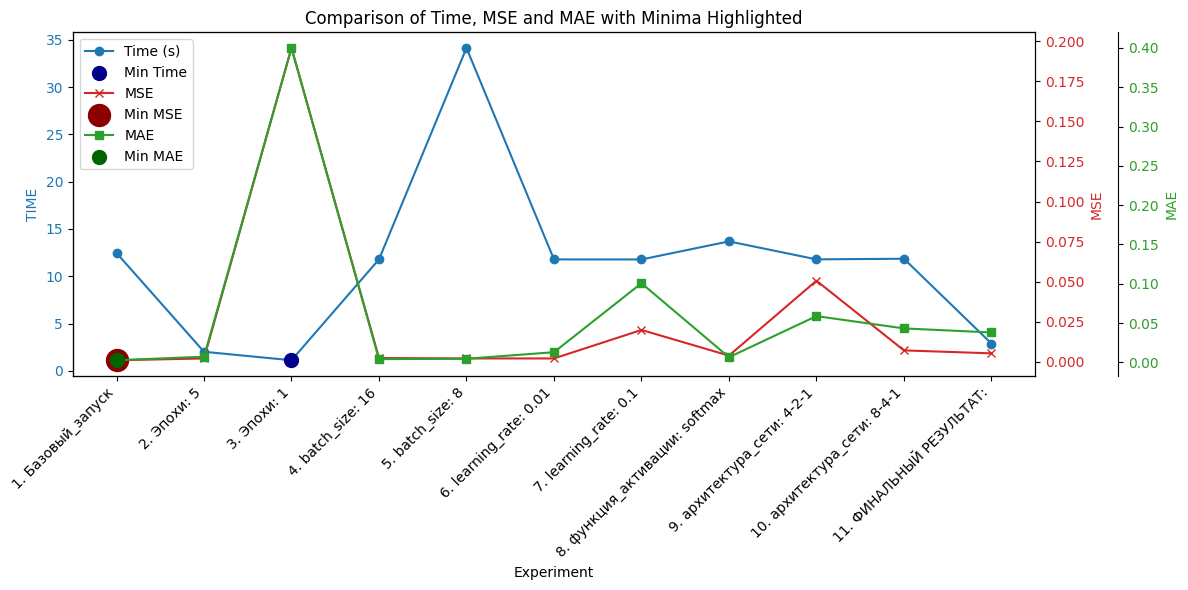

In [129]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(12,6))

experiments = df_results['Experiment']

# TIME
ax1.set_xlabel('Experiment')
ax1.set_ylabel('TIME', color='tab:blue')
ax1.plot(experiments, df_results['TIME'], color='tab:blue', marker='o', label='Time (s)')
ax1.tick_params(axis='y', labelcolor='tab:blue')
plt.xticks(rotation=45, ha='right')

min_time_idx = df_results['TIME'].idxmin()
ax1.scatter(experiments[min_time_idx], df_results['TIME'][min_time_idx], 
            color='darkblue', s=100, zorder=5, label='Min Time')

# MSE
ax2 = ax1.twinx()
ax2.set_ylabel('MSE', color='tab:red')
ax2.plot(experiments, df_results['MSE'], color='tab:red', marker='x', label='MSE')
ax2.tick_params(axis='y', labelcolor='tab:red')

min_mse_idx = df_results['MSE'].idxmin()
ax2.scatter(experiments[min_mse_idx], df_results['MSE'][min_mse_idx], 
            color='darkred', s=250, zorder=5, label='Min MSE')

# MAE
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))
ax3.set_ylabel('MAE', color='tab:green')
ax3.plot(experiments, df_results['MAE'], color='tab:green', marker='s', label='MAE')
ax3.tick_params(axis='y', labelcolor='tab:green')

min_mae_idx = df_results['MAE'].idxmin()
ax3.scatter(experiments[min_mae_idx], df_results['MAE'][min_mae_idx], 
            color='darkgreen', s=100, zorder=5, label='Min MAE')

lines, labels = [], []
for ax in [ax1, ax2, ax3]:
    line, label = ax.get_legend_handles_labels()
    lines += line
    labels += label
ax1.legend(lines, labels, loc='upper left')

plt.title('Comparison of Time, MSE and MAE with Minima Highlighted')
plt.tight_layout()
plt.show()
